# Proyek Klasifikasi Gambar: Vehicle Classification
- **Nama:** Mohammad Iqbal Jaffar
- **Email:** iqbaljaffar1108@gmail.com
- **ID Dicoding:** miqbalj

## Import Semua Packages/Library yang Digunakan

In [1]:
from google.colab import files
import os
import zipfile
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Install split-folders jika belum ada
try:
    import splitfolders
except ImportError:
    print("Library splitfolders belum terinstall. Menginstall sekarang...")
    !pip install -q split-folders
    import splitfolders
    print("Library splitfolders berhasil diinstall.")

Library splitfolders belum terinstall. Menginstall sekarang...
Library splitfolders berhasil diinstall.


In [3]:
# Install tensorflowjs jika belum ada
try:
    import tensorflowjs as tfjs
except ImportError:
    print("\nLibrary tensorflowjs belum terinstall. Menginstall sekarang...")
    !pip install -q tensorflowjs
    import tensorflowjs as tfjs
    print("Library tensorflowjs berhasil diinstall.")

print(f"TensorFlow version: {tf.__version__}")


Library tensorflowjs belum terinstall. Menginstall sekarang...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


Library tensorflowjs berhasil diinstall.
TensorFlow version: 2.18.0


## Data Preparation

In [4]:
print("Silakan unggah file kaggle.json Anda:")
try:
    uploaded = files.upload()
    if 'kaggle.json' not in uploaded:
        raise KeyError("'kaggle.json' not found in uploaded files.")
    print("\nFile kaggle.json berhasil diunggah.")
except Exception as e:
    print(f"Error saat mengunggah file: {e}")
    raise SystemExit("Proses dihentikan karena kaggle.json tidak terunggah.")

Silakan unggah file kaggle.json Anda:


Saving kaggle.json to kaggle.json

File kaggle.json berhasil diunggah.


In [5]:
print("\nMengonfigurasi Kaggle API...")
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API berhasil dikonfigurasi.")


Mengonfigurasi Kaggle API...
Kaggle API berhasil dikonfigurasi.


### Data Loading

In [6]:
print("\nMengunduh dataset 'vehicle-classification' dari Kaggle...")
!kaggle datasets download -d mohamedmaher5/vehicle-classification -q --force
print("Dataset berhasil diunduh.")


Mengunduh dataset 'vehicle-classification' dari Kaggle...
Dataset URL: https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification
License(s): CC0-1.0
Dataset berhasil diunduh.


In [7]:
# Hapus direktori data lama jika ada, untuk ekstraksi bersih
raw_data_dir = 'vehicle_classification_data'
if os.path.exists(raw_data_dir):
    shutil.rmtree(raw_data_dir)
os.makedirs(raw_data_dir, exist_ok=True)

In [8]:
print("\nMengekstrak dataset...")
with zipfile.ZipFile('vehicle-classification.zip', 'r') as zip_ref:
    zip_ref.extractall(raw_data_dir)
print(f"Dataset berhasil diekstrak ke folder '{raw_data_dir}'.")

if os.path.exists('vehicle-classification.zip'):
    os.remove('vehicle-classification.zip')
    print("File zip 'vehicle-classification.zip' telah dihapus.")


Mengekstrak dataset...
Dataset berhasil diekstrak ke folder 'vehicle_classification_data'.
File zip 'vehicle-classification.zip' telah dihapus.


In [9]:
# Verifikasi isi folder dataset dan temukan path yang benar
base_dataset_dir = None
# Path yang umum setelah ekstraksi dari Kaggle untuk dataset ini
expected_path1 = os.path.join(raw_data_dir, 'Vehicles')
expected_path2 = os.path.join(raw_data_dir, 'Vehicle Classification', 'Vehicles') # Struktur lain yang mungkin
expected_path3 = os.path.join(raw_data_dir, 'data', 'Vehicles') # Struktur lain yang mungkin

if os.path.exists(expected_path1) and os.listdir(expected_path1):
    base_dataset_dir = expected_path1
elif os.path.exists(expected_path2) and os.listdir(expected_path2):
    base_dataset_dir = expected_path2
elif os.path.exists(expected_path3) and os.listdir(expected_path3):
    base_dataset_dir = expected_path3
else:
    # Pencarian lebih umum jika path di atas tidak ditemukan
    print("Path dataset standar tidak ditemukan, mencoba mencari 'Vehicles' secara rekursif...")
    for root, dirs, _ in os.walk(raw_data_dir):
        if 'Vehicles' in dirs:
            potential_path = os.path.join(root, 'Vehicles')
            # Pastikan direktori 'Vehicles' ini berisi subfolder kelas
            if any(os.path.isdir(os.path.join(potential_path, item)) for item in os.listdir(potential_path)):
                base_dataset_dir = potential_path
                print(f"Direktori 'Vehicles' yang valid ditemukan di: {base_dataset_dir}")
                break
    if not base_dataset_dir:
        print(f"Error: Direktori dataset 'Vehicles' yang berisi kelas-kelas kendaraan tidak ditemukan setelah ekstraksi di dalam '{raw_data_dir}'.")
        print("Silakan periksa struktur file zip yang diunduh.")
        print("Isi dari 'vehicle_classification_data':")
        for item in os.listdir(raw_data_dir):
            print(f"- {item}")
        raise SystemExit("Proses dihentikan karena struktur dataset tidak sesuai harapan.")

print(f"\nDirektori dataset utama yang akan digunakan: '{base_dataset_dir}'")
print("Isi dari direktori dataset utama:")
for item in os.listdir(base_dataset_dir):
    print(f"- {item}")


Direktori dataset utama yang akan digunakan: 'vehicle_classification_data/Vehicles'
Isi dari direktori dataset utama:
- Planes
- Cars
- Bikes
- Ships
- Motorcycles
- Auto Rickshaws
- Trains


### Data Preprocessing

In [10]:
original_dataset_dir = base_dataset_dir
output_dataset_dir = 'vehicle_data_split'

In [11]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
BATCH_SIZE = 32
EPOCHS = 75 # Tingkatkan sedikit, EarlyStopping akan mengontrolnya
INIT_LR = 0.0005 # Learning rate awal yang sedikit lebih kecil

In [12]:
if os.path.exists(original_dataset_dir):
    class_names = sorted([d for d in os.listdir(original_dataset_dir) if os.path.isdir(os.path.join(original_dataset_dir, d))])
    NUM_CLASSES = len(class_names)
    print(f"\nDirektori dataset asli: {original_dataset_dir}")
    print(f"Kelas yang terdeteksi ({NUM_CLASSES}): {class_names}")
    if NUM_CLASSES == 0:
        print("Error: Tidak ada subdirektori kelas yang ditemukan di 'original_dataset_dir'.")
        raise SystemExit("Hentikan eksekusi.")
else:
    print(f"Error: Direktori dataset asli '{original_dataset_dir}' tidak ditemukan.")
    raise SystemExit("Hentikan eksekusi karena direktori dataset tidak ditemukan.")


Direktori dataset asli: vehicle_classification_data/Vehicles
Kelas yang terdeteksi (7): ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']


In [13]:
if os.path.exists(output_dataset_dir):
    print(f"Menghapus direktori '{output_dataset_dir}' yang sudah ada...")
    shutil.rmtree(output_dataset_dir)
print(f"Direktori output untuk data split: {output_dataset_dir}")

Direktori output untuk data split: vehicle_data_split


#### Split Dataset

In [14]:
print("\nMembagi dataset menjadi train, validation, dan test set...")
splitfolders.ratio(
    original_dataset_dir,
    output=output_dataset_dir,
    seed=42,
    ratio=(.7, .15, .15), # 70% train, 15% validation, 15% test
    group_prefix=None,
    move=False
)
print("Pembagian dataset selesai.")


Membagi dataset menjadi train, validation, dan test set...


Copying files: 5590 files [00:07, 719.39 files/s]

Pembagian dataset selesai.


In [15]:
train_dir = os.path.join(output_dataset_dir, 'train')
validation_dir = os.path.join(output_dataset_dir, 'val')
test_dir = os.path.join(output_dataset_dir, 'test')

In [16]:
print(f"\nPath direktori training: {train_dir}")
print(f"Path direktori validasi: {validation_dir}")
print(f"Path direktori testing: {test_dir}")


Path direktori training: vehicle_data_split/train
Path direktori validasi: vehicle_data_split/val
Path direktori testing: vehicle_data_split/test


In [17]:
def count_files_in_subdirs(directory):
    total_files = 0
    if not os.path.exists(directory): return 0, {}
    counts_per_class = {}
    for class_name in class_names: # Iterasi berdasarkan class_names yang sudah terdeteksi
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
            counts_per_class[class_name] = count
            total_files += count
    return total_files, counts_per_class

In [18]:
num_train_images, train_class_counts = count_files_in_subdirs(train_dir)
num_val_images, val_class_counts = count_files_in_subdirs(validation_dir)
num_test_images, test_class_counts = count_files_in_subdirs(test_dir)

In [19]:
print(f"\nJumlah gambar training: {num_train_images}")
print(f"Detail per kelas (train): {train_class_counts}")
print(f"Jumlah gambar validasi: {num_val_images}")
print(f"Detail per kelas (val): {val_class_counts}")
print(f"Jumlah gambar testing: {num_test_images}")
print(f"Detail per kelas (test): {test_class_counts}")


Jumlah gambar training: 3913
Detail per kelas (train): {'Auto Rickshaws': 560, 'Bikes': 560, 'Cars': 553, 'Motorcycles': 560, 'Planes': 560, 'Ships': 560, 'Trains': 560}
Jumlah gambar validasi: 838
Detail per kelas (val): {'Auto Rickshaws': 120, 'Bikes': 120, 'Cars': 118, 'Motorcycles': 120, 'Planes': 120, 'Ships': 120, 'Trains': 120}
Jumlah gambar testing: 839
Detail per kelas (test): {'Auto Rickshaws': 120, 'Bikes': 120, 'Cars': 119, 'Motorcycles': 120, 'Planes': 120, 'Ships': 120, 'Trains': 120}


In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2], # Penambahan brightness augmentation
    fill_mode='nearest'
)

In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    classes=class_names # Pastikan urutan kelas konsisten
)

Found 3911 images belonging to 7 classes.


In [23]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=class_names # Pastikan urutan kelas konsisten
)

Found 838 images belonging to 7 classes.


In [24]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, # Bisa disamakan atau 1 untuk evaluasi
    class_mode='categorical',
    shuffle=False,
    classes=class_names # Pastikan urutan kelas konsisten
)

Found 838 images belonging to 7 classes.


In [25]:
print("\nKelas dari train_generator:", train_generator.class_indices)
print("Kelas dari validation_generator:", validation_generator.class_indices)
print("Kelas dari test_generator:", test_generator.class_indices)

if not (train_generator.class_indices == validation_generator.class_indices == test_generator.class_indices):
    print("Peringatan: Indeks kelas tidak konsisten antar generator!")
else:
    print("Indeks kelas konsisten antar generator.")


Kelas dari train_generator: {'Auto Rickshaws': 0, 'Bikes': 1, 'Cars': 2, 'Motorcycles': 3, 'Planes': 4, 'Ships': 5, 'Trains': 6}
Kelas dari validation_generator: {'Auto Rickshaws': 0, 'Bikes': 1, 'Cars': 2, 'Motorcycles': 3, 'Planes': 4, 'Ships': 5, 'Trains': 6}
Kelas dari test_generator: {'Auto Rickshaws': 0, 'Bikes': 1, 'Cars': 2, 'Motorcycles': 3, 'Planes': 4, 'Ships': 5, 'Trains': 6}
Indeks kelas konsisten antar generator.


## Modelling

In [26]:
model = Sequential([
    Input(shape=IMG_SHAPE), # Menggunakan Input layer eksplisit

    # Blok Konvolusi 1
    Conv2D(32, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # Blok Konvolusi 2
    Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # Blok Konvolusi 3
    Conv2D(128, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # Blok Konvolusi 4
    Conv2D(256, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # Blok Konvolusi 5 (Tambahan)
    Conv2D(512, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    Flatten(),

    # Lapisan Fully Connected
    Dense(512, use_bias=False, kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4), # Dropout rate disesuaikan

    # Lapisan Output
    Dense(NUM_CLASSES, activation='softmax')
])

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 512)      │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,771,495 (22.02 MB)

 Trainable params: 5,768,487 (22.01 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [28]:
model.compile(
    optimizer=Adam(learning_rate=INIT_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model berhasil dikompilasi.")

Model berhasil dikompilasi.


In [29]:
checkpoint_path = "best_vehicle_classifier_model.keras"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [30]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Sedikit lebih sabar
    restore_best_weights=True,
    verbose=1
)

In [31]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=7, # Sedikit lebih sabar
    min_lr=1e-7, # Batas bawah learning rate yang lebih kecil
    verbose=1
)

In [32]:
callbacks_list = [model_checkpoint, early_stopping, reduce_lr]
print("Callbacks berhasil didefinisikan.")

Callbacks berhasil didefinisikan.


In [33]:
print("\nMemulai proses training model...")
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // BATCH_SIZE), # Pastikan steps_per_epoch >= 1
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=max(1, validation_generator.samples // BATCH_SIZE), # Pastikan validation_steps >= 1
    callbacks=callbacks_list,
    verbose=1
)
print("Training model selesai.")


Memulai proses training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/75
 18/122 ━━━━━━━━━━━━━━━━━━━━ 37s 363ms/step - accuracy: 0.2990 - loss: 2.3252

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.4210 - loss: 1.8949
Epoch 1: val_accuracy improved from -inf to 0.14423, saving model to best_vehicle_classifier_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 76s 529ms/step - accuracy: 0.4217 - loss: 1.8927 - val_accuracy: 0.1442 - val_loss: 7.1438 - learning_rate: 5.0000e-04
Epoch 2/75
  1/122 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6250 - loss: 1.2514

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.14423
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.6250 - loss: 1.2514 - val_accuracy: 0.1442 - val_loss: 7.0348 - learning_rate: 5.0000e-04
Epoch 3/75
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.6129 - loss: 1.2537
Epoch 3: val_accuracy did not improve from 0.14423
122/122 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - accuracy: 0.6131 - loss: 1.2533 - val_accuracy: 0.1442 - val_loss: 5.9224 - learning_rate: 5.0000e-04
Epoch 4/75
  1/122 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7188 - loss: 1.1064
Epoch 4: val_accuracy did not improve from 0.14423
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.7188 - loss: 1.1064 - val_accuracy: 0.1442 - val_loss: 5.9591 - learning_rate: 5.0000e-04
Epoch 5/75
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6778 - loss: 1.0878
Epoch 5: val_accuracy improved from 0.14423 to 0.37861, saving model to best_vehicle_classifier_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 64s 52

## Evaluasi dan Visualisasi

In [34]:
print("\nMemuat model terbaik untuk evaluasi akhir...")
# Model 'model' di memory sudah merupakan model dengan bobot terbaik karena restore_best_weights=True
# Namun, untuk konsistensi dan jika terjadi interupsi, kita bisa load dari checkpoint.
try:
    loaded_best_model = tf.keras.models.load_model(checkpoint_path)
    print(f"Model terbaik dimuat dari {checkpoint_path}")
except Exception as e:
    print(f"Gagal memuat model dari checkpoint: {e}. Menggunakan model terakhir dari training.")
    loaded_best_model = model # Fallback ke model yang ada di memori

print("\nMengevaluasi model pada test set...")
test_loss, test_accuracy = loaded_best_model.evaluate(
    test_generator,
    steps=max(1, test_generator.samples // BATCH_SIZE), # Pastikan steps >= 1
    verbose=1
)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Ambil akurasi training terakhir dari history (jika history ada)
if history and 'accuracy' in history.history:
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    print(f"Final Training Accuracy (dari history): {final_train_accuracy*100:.2f}%")
    print(f"Final Validation Accuracy (dari history): {final_val_accuracy*100:.2f}%")
else: # Jika training diinterupsi atau history tidak lengkap, evaluasi ulang pada training set
    print("Mengevaluasi ulang pada training set...")
    train_loss, train_accuracy_eval = loaded_best_model.evaluate(train_generator, steps=max(1, train_generator.samples // BATCH_SIZE), verbose=0)
    print(f"Evaluated Training Accuracy: {train_accuracy_eval*100:.2f}%")


Memuat model terbaik untuk evaluasi akhir...
Model terbaik dimuat dari best_vehicle_classifier_model.keras

Mengevaluasi model pada test set...
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.9358 - loss: 0.3984

Test Loss: 0.3890
Test Accuracy: 93.39%
Final Training Accuracy (dari history): 84.38%
Final Validation Accuracy (dari history): 92.07%


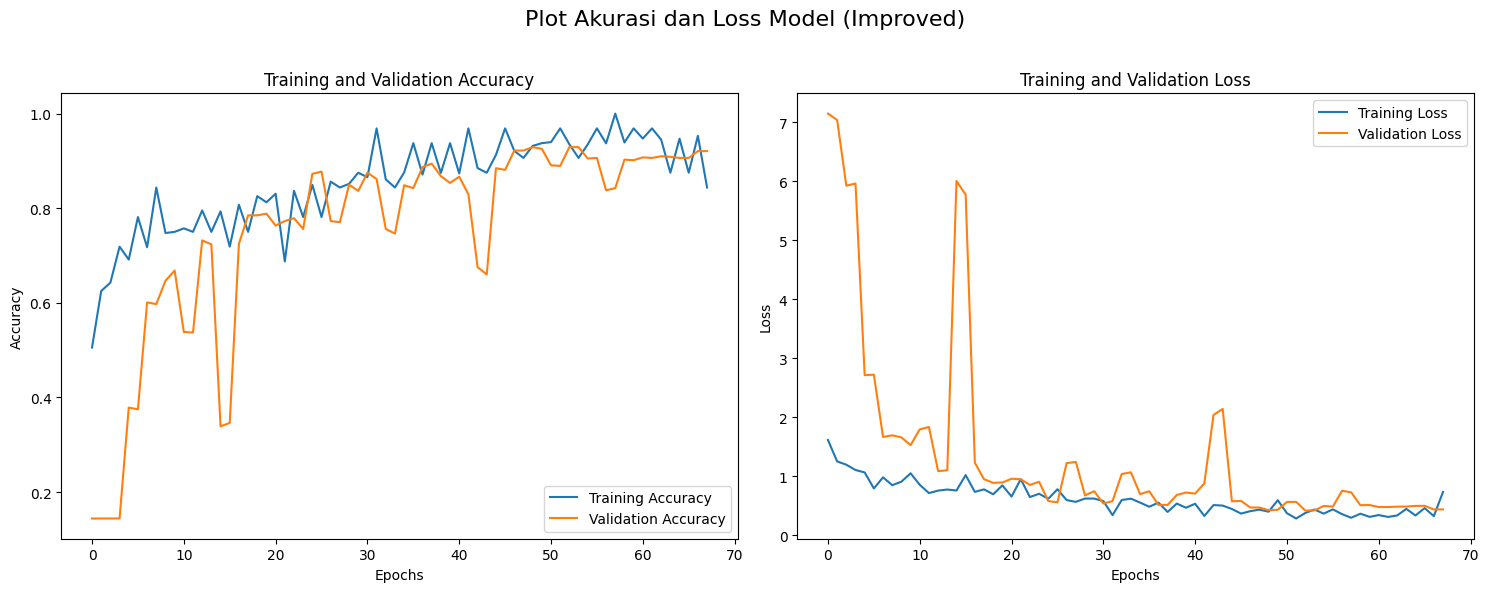

In [35]:
if history and all(k in history.history for k in ['accuracy', 'val_accuracy', 'loss', 'val_loss']):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.suptitle("Plot Akurasi dan Loss Model (Improved)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("Tidak dapat membuat plot, history training tidak lengkap.")

## Konversi Model

In [38]:
submission_dir = 'submission'
tfjs_submission_dir = os.path.join(submission_dir, 'tfjs_model')
tflite_submission_dir = os.path.join(submission_dir, 'tflite')
saved_model_submission_dir = os.path.join(submission_dir, 'saved_model')

# Buat direktori submission utama dan sub-direktori jika belum ada
os.makedirs(submission_dir, exist_ok=True)
os.makedirs(tfjs_submission_dir, exist_ok=True)
os.makedirs(tflite_submission_dir, exist_ok=True)
# Pastikan direktori untuk SavedModel ada dan kosong sebelum menyimpan
if os.path.exists(saved_model_submission_dir):
    print(f"Menghapus direktori '{saved_model_submission_dir}' yang sudah ada sebelum menyimpan SavedModel baru...")
    shutil.rmtree(saved_model_submission_dir)
os.makedirs(saved_model_submission_dir, exist_ok=True)

print(f"\nStruktur folder '{submission_dir}' dan sub-direktorinya telah disiapkan.")

Menghapus direktori 'submission/saved_model' yang sudah ada sebelum menyimpan SavedModel baru...

Struktur folder 'submission' dan sub-direktorinya telah disiapkan.


In [42]:
print(f"\nMenyimpan model ke format SavedModel di direktori: {saved_model_submission_dir}...")
# `export` menyimpan ke dalam direktori yang namanya adalah nama model itu sendiri, jadi kita tidak perlu membuat subdirektori lagi.
# Jika `saved_model_submission_dir` sudah ada isinya, hapus dulu.
if os.path.exists(saved_model_submission_dir) and os.listdir(saved_model_submission_dir):
     print(f"Menghapus isi '{saved_model_submission_dir}' sebelum menyimpan SavedModel baru...")
     shutil.rmtree(saved_model_submission_dir)
     # os.makedirs(saved_model_submission_dir, exist_ok=True) # Tidak perlu membuat ulang, export akan membuatnya jika tidak ada

# Menggunakan model.export() untuk SavedModel format
loaded_best_model.export(saved_model_submission_dir)

print(f"Model berhasil disimpan sebagai SavedModel di '{saved_model_submission_dir}'.")
print(f"Isi direktori SavedModel:")
for item in os.listdir(saved_model_submission_dir):
    print(f"- {item}")


Menyimpan model ke format SavedModel di direktori: submission/saved_model...
Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  135623862020496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862017424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862018960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862017232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862018384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862018192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862020880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862021456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862021264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

In [43]:
tflite_model_filename = 'model.tflite'
tflite_model_path_final = os.path.join(tflite_submission_dir, tflite_model_filename)
label_filename = 'label.txt'
label_path_final = os.path.join(tflite_submission_dir, label_filename)

print(f"\nMengonversi model ke format TF-Lite dan menyimpannya sebagai: {tflite_model_path_final}...")
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_best_model)
# Atau dari SavedModel:
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_submission_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

with open(tflite_model_path_final, 'wb') as f:
    f.write(tflite_model_quant)
print(f"Model berhasil dikonversi dan disimpan sebagai TF-Lite di '{tflite_model_path_final}'.")
print(f"Ukuran model TF-Lite: {os.path.getsize(tflite_model_path_final) / 1024:.2f} KB")

# Simpan label.txt
print(f"Menyimpan label kelas ke: {label_path_final}")
with open(label_path_final, 'w') as f:
    for class_name in class_names: # Menggunakan class_names yang sudah diurutkan
        f.write(f"{class_name}\n")
print("File label.txt berhasil disimpan.")


Mengonversi model ke format TF-Lite dan menyimpannya sebagai: submission/tflite/model.tflite...
Saved artifact at '/tmp/tmphfah7k3s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  135623862020496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862017424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862018960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862017232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862018384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862018192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862020880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862021456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135623862021264: TensorSpec(shape=(), dtype=tf.resource, n

In [44]:
print(f"\nMengonversi model ke format TFJS dan menyimpannya di direktori: {tfjs_submission_dir}...")
if os.path.exists(tfjs_submission_dir) and os.listdir(tfjs_submission_dir):
    print(f"Menghapus isi '{tfjs_submission_dir}' sebelum menyimpan model TFJS baru...")
    shutil.rmtree(tfjs_submission_dir)
    os.makedirs(tfjs_submission_dir, exist_ok=True)

# Menggunakan konversi dari SavedModel (lebih robust untuk beberapa kasus)
# Command line tool adalah cara yang umum dan stabil
try:
    print(f"Mencoba konversi TFJS dari SavedModel: {saved_model_submission_dir}")
    !tensorflowjs_converter \
        --input_format=tf_saved_model \
        --output_format=tfjs_graph_model \
        {saved_model_submission_dir} \
        {tfjs_submission_dir}
    print(f"Model TFJS berhasil dikonversi dari SavedModel ke '{tfjs_submission_dir}'.")
except Exception as e_sm:
    print(f"Konversi TFJS dari SavedModel gagal: {e_sm}")
    print(f"Mencoba konversi TFJS dari file Keras: {checkpoint_path}")
    try:
        !tensorflowjs_converter \
            --input_format=keras \
            {checkpoint_path} \
            {tfjs_submission_dir}
        print(f"Model TFJS berhasil dikonversi dari Keras model ke '{tfjs_submission_dir}'.")
    except Exception as e_keras:
        print(f"Konversi TFJS dari Keras model juga gagal: {e_keras}")
        print("Gagal mengonversi model ke format TFJS.")

print(f"Isi direktori TFJS model ({tfjs_submission_dir}):")
if os.path.exists(tfjs_submission_dir):
    for item in os.listdir(tfjs_submission_dir):
        print(f"- {item}")
else:
    print("Direktori TFJS tidak ditemukan.")


Mengonversi model ke format TFJS dan menyimpannya di direktori: submission/tfjs_model...
Mencoba konversi TFJS dari SavedModel: submission/saved_model
2025-05-27 06:53:08.747211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748328788.767744   16575 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748328788.774017   16575 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-27 06:53:13.220143: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environm

## Inference (Optional)

In [45]:
from tensorflow.keras.preprocessing import image
import random


Label kelas untuk inferensi: ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']

Gambar yang dipilih untuk inferensi: vehicle_data_split/test/Trains/Train (782).jpg
Kelas Sebenarnya: Trains
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


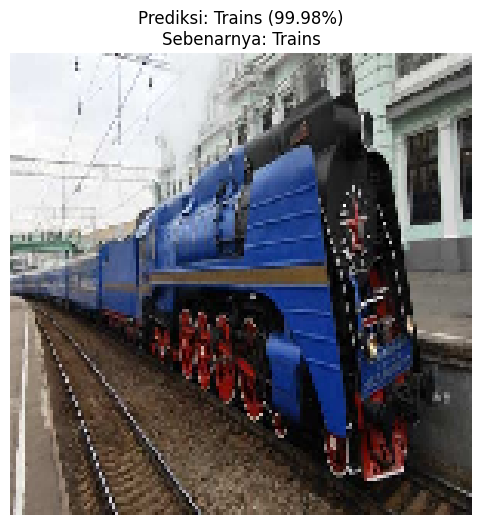


--- Bukti Inferensi ---
File Gambar: Train (782).jpg
Kelas Prediksi: Trains | Keyakinan: 99.98%
--- Akhir Bukti Inferensi ---

Proses Selesai. Periksa folder 'submission' untuk hasilnya.


In [46]:
# Menggunakan model Keras yang sudah dimuat (loaded_best_model) untuk inferensi
inference_model = loaded_best_model
class_labels = sorted(list(train_generator.class_indices.keys())) # Pastikan urutan label konsisten
print(f"\nLabel kelas untuk inferensi: {class_labels}")

try:
    # Pilih kelas acak dari direktori test
    if not os.path.exists(test_dir) or not os.listdir(test_dir):
        print("Direktori test kosong atau tidak ditemukan.")
    else:
        valid_classes_in_test = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d)) and d in class_labels]
        if not valid_classes_in_test:
            print("Tidak ada direktori kelas yang valid di dalam folder test.")
        else:
            random_class = random.choice(valid_classes_in_test)
            random_class_dir = os.path.join(test_dir, random_class)

            if not os.listdir(random_class_dir):
                print(f"Tidak ada gambar di direktori kelas acak yang dipilih: {random_class_dir}")
            else:
                random_image_name = random.choice([f for f in os.listdir(random_class_dir) if os.path.isfile(os.path.join(random_class_dir, f))])
                img_path = os.path.join(random_class_dir, random_image_name)

                print(f"\nGambar yang dipilih untuk inferensi: {img_path}")
                print(f"Kelas Sebenarnya: {random_class}")

                img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array /= 255.0  # Normalisasi

                predictions = inference_model.predict(img_array)
                predicted_class_index = np.argmax(predictions[0])
                predicted_class_label = class_labels[predicted_class_index]
                confidence = np.max(predictions[0]) * 100

                plt.figure(figsize=(6,6))
                plt.imshow(img)
                plt.title(f"Prediksi: {predicted_class_label} ({confidence:.2f}%)\nSebenarnya: {random_class}")
                plt.axis('off')
                plt.show()

                print(f"\n--- Bukti Inferensi ---")
                print(f"File Gambar: {random_image_name}")
                print(f"Kelas Prediksi: {predicted_class_label} | Keyakinan: {confidence:.2f}%")
                print(f"--- Akhir Bukti Inferensi ---")

except Exception as e:
    print(f"Error saat melakukan inferensi: {e}")
    import traceback
    traceback.print_exc()

print("\nProses Selesai. Periksa folder 'submission' untuk hasilnya.")

In [48]:
print("\nMembuat file zip dari folder submission...")
shutil.make_archive('submission', 'zip', '.', 'submission')
print("File submission.zip berhasil dibuat.")
try:
    files.download('submission.zip')
    print("Unduhan submission.zip dimulai.")
except Exception as e:
    print(f"Gagal mengunduh submission.zip secara otomatis: {e}")
    print("Anda bisa mengunduhnya manual dari panel file di sebelah kiri.")


Membuat file zip dari folder submission...
File submission.zip berhasil dibuat.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Unduhan submission.zip dimulai.
